In [1]:
from quri_parts.core.operator import Operator, pauli_label
from scipy.optimize import minimize
import numpy as np
from quri_parts.circuit import LinearMappedUnboundParametricQuantumCircuit, Parameter
from quri_parts.core.state import quantum_state
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
import networkx as nx

In [123]:
# Build an example graph
# graph1 = {
#     'nodes': list(range(4)),
#     'edges': [
#         (0, 1), (0, 2), (1, 2),
#         (0, 3)
#     ]
# }

# graph2 = {
#     'nodes': list(range(4)),
#     'edges': [
#         (0, 1), (0, 2), (1, 3),
#         (0, 3)
#     ]
# }

graph1 = {
    'nodes': list(range(3)),
    'edges': [
        (0, 2), (1, 2), (0, 1)
    ]
}

graph2 = {
    'nodes': list(range(3)),
    'edges': [
        (0, 1), (0, 2), (1, 2)
    ]
}

# graph3 = {
#     'nodes': list(range(4)),
#     'edges': [
#         (0, 1), (0, 2), (1, 2),
#         (0, 3), (2, 3)
#     ]
# }

G1 = nx.Graph()
G1.add_nodes_from(graph1['nodes'])
G1.add_edges_from(graph1['edges'])

G2 = nx.Graph()
G2.add_nodes_from(graph2['nodes'])
G2.add_edges_from(graph2['edges'])

# G3 = nx.Graph()
# G3.add_nodes_from(graph3['nodes'])
# G3.add_edges_from(graph3['edges'])

nodes = G1.nodes()
num_qubits = len(nodes)

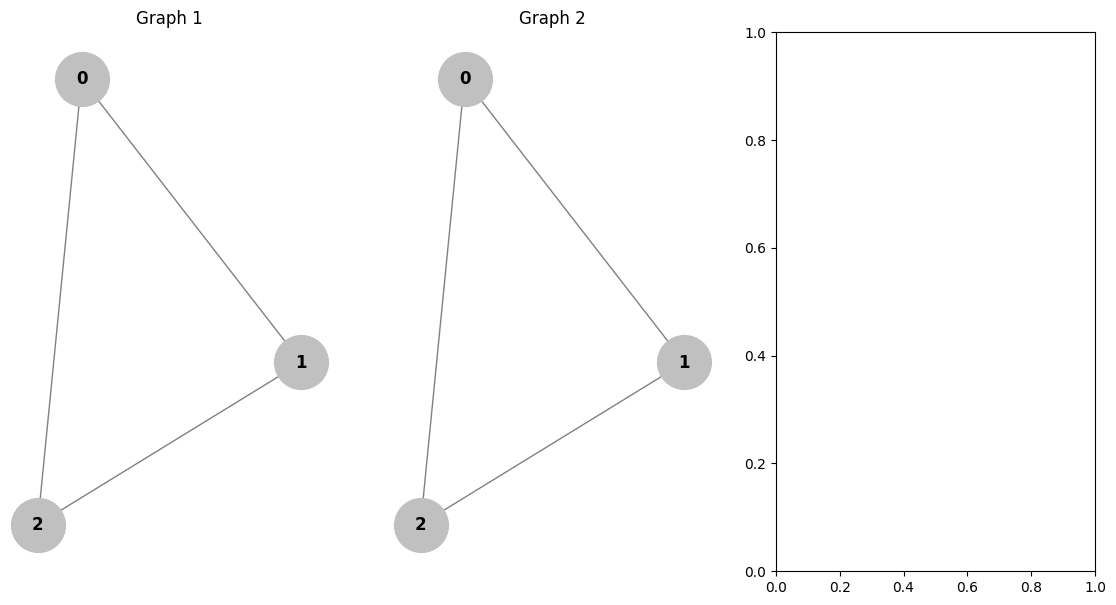

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

full_graph_color = "#C0C0C0"
pos = nx.spring_layout(G1, seed=42)
# 創建子圖
fig, axes = plt.subplots(1, 3, figsize=(14, 7))

nx.draw(G1, pos, with_labels=True, node_color=full_graph_color, edge_color="gray",
        node_size=1500, font_size=12, font_weight="bold", ax=axes[0])
axes[0].set_title("Graph 1")

nx.draw(G2, pos, with_labels=True, node_color=full_graph_color, edge_color="gray",
        node_size=1500, font_size=12, font_weight="bold", ax=axes[1])
axes[1].set_title("Graph 2")

# nx.draw(G3, pos, with_labels=True, node_color=full_graph_color, edge_color="gray",
#         node_size=1500, font_size=12, font_weight="bold", ax=axes[2])
# axes[2].set_title("Graph 3")

plt.show()

In [ ]:
# Define Hamiltonian of Graph isomorphism problem
def qubit_index(u, v, N):
    """
    將 (u, v) 對應到單一 qubit 的索引。
    假設 u, v ∈ {0, 1, ..., N-1}。
    """
    return u*N + v

def add_term(obs_dict: dict, term_str: str, coeff: float) -> None:
    """
    將 'term_str' 對應的 Pauli 標籤累加到 obs_dict 中，係數為 coeff。
    若 term_str 為空字串，表示 identity。
    """
    key = pauli_label(term_str)
    if key in obs_dict:
        obs_dict[key] += coeff
    else:
        obs_dict[key] = coeff
    # key = pauli_label(term_str) if term_str.strip() else ()
    # obs_dict[key] = obs_dict.get(key, 0.0) + coeff

def add_x_uv(obs_dict, u, v, coeff, N) -> None:
    """
    加上 coeff * x_{u,v} = coeff * (0.5 - 0.5 Z_{u,v})
    """
    q = qubit_index(u, v, N)
    add_term(obs_dict, {}, 0.5*coeff)          # 0.5 * coeff * I
    add_term(obs_dict, f"Z{q}", -0.5*coeff)    # -0.5 * coeff * Z_q

def add_x_uv_product(obs_dict, u1, v1, u2, v2, coeff, N) -> None: 
    """
    將 coeff * x_{u1,v1} * x_{u2,v2} 展開為 Pauli 字典，並累加到 obs_dict。
    x_{u,v} = 0.5 - 0.5 Z_{u,v}
    """
    q1 = qubit_index(u1, v1, N)
    q2 = qubit_index(u2, v2, N)
    # x_{u1,v1} x_{u2,v2} = (0.5 - 0.5Z_{q1}) (0.5 - 0.5Z_{q2})
    #                     = 0.25 - 0.25Z_{q1} - 0.25Z_{q2} + 0.25Z_{q1}Z_{q2}
    # 然後整體再乘以 coeff
    c = 0.25 * coeff
    add_term(obs_dict, {}, c)                 # 0.25 * I
    add_term(obs_dict, f"Z{q1}", -c)          # -0.25 * Z_{q1}
    add_term(obs_dict, f"Z{q2}", -c)          # -0.25 * Z_{q2}
    # 若 q1 != q2，就可以加雙 Z 項；若 q1 == q2（不應發生在此場景），需注意 squares
    if q1 != q2:
        add_term(obs_dict, f"Z{q1} Z{q2}", c) # +0.25 * Z_{q1}Z_{q2}
    else:
        # x_{q1}^2 = x_{q1}, 不過在 GI 問題中，(u1,v1)≠(u2,v2) 應不會碰到
        pass

def build_graph_iso_observable(G1: nx.Graph, G2: nx.Graph, A: float, B: float):
    """
    回傳一個 dict (可用 Operator(...) 包裝) 對應 GI Hamiltonian:
      H = H_A + H_B.
    假設 G1, G2 都有 N 個頂點，編號 0..N-1。
    """
    obs_dict = {}
    try:
        len(G1.nodes)==len(G2.nodes)
    except:
        print("Number of nodes of two graphes have to be the same.")

    N = len(G1.nodes())

    # ========== Part 1: H_A ==========
    # (1) 每個 v, 令 sum_u x_{u,v} = 1
    for v in range(N):
        # (1 - sum_u x_{u,v})^2 = 1 - 2 sum_u x_{u,v} + sum_{u1,u2} x_{u1,v} x_{u2,v}
        # 其中 x_{u,v}^2 = x_{u,v}, 但我們直接用 u1,u2 全遍歷，u1==u2 時一樣
        # 乘上 A
        add_term(obs_dict, {}, A)  # 來自 "1" 的項
        for u in range(N):
            # -2 * x_{u,v}
            add_x_uv(obs_dict, u, v, coeff=A/2, N=N)
        # x_{u1,v} x_{u2,v}
        for u1 in range(N):
            for u2 in range(N):
                add_x_uv_product(obs_dict, u1, v, u2, v, coeff=A/4, N=N)

    # (2) 每個 u, 令 sum_v x_{u,v} = 1
    for u in range(N):
        add_term(obs_dict, {}, A)
        for v in range(N):
            add_x_uv(obs_dict, u, v, coeff=A, N=N)
        for v1 in range(N):
            for v2 in range(N):
                add_x_uv_product(obs_dict, u, v1, u, v2, coeff=A/4, N=N)

    # ========== Part 2: H_B ==========
    # 若 (u1,u2) ∈ E1, (v1,v2) 不在 E2, 就加 B * x_{u1,v1} x_{u2,v2}
    # 若 (u1,u2) 不在 E1, (v1,v2) ∈ E2, 也加 B * x_{u1,v1} x_{u2,v2}
    # 注意無向邊 => 只考慮 u1 < u2 / v1 < v2 來避免重複
    E1 = set()
    for (u1,u2) in G1.edges():
        if u1>u2: u1,u2 = u2,u1
        E1.add((u1,u2))

    E2 = set()
    for (v1,v2) in G2.edges():
        if v1>v2: v1,v2 = v2,v1
        E2.add((v1,v2))

    for u1 in range(N):
        for u2 in range(u1+1, N):
            inE1 = ((u1,u2) in E1)
            for v1 in range(N):
                for v2 in range(v1+1, N):
                    inE2 = ((v1,v2) in E2)
                    # 如果 "在 E1 但不在 E2" 或 "不在 E1 但在 E2"
                    if inE1 != inE2:
                        # 懲罰 x_{u1,v1} x_{u2,v2}
                        add_x_uv_product(obs_dict, u1,v1, u2,v2, B/4, N=N)

    return Operator(obs_dict)

cost_observable = build_graph_iso_observable(G1=G1, G2=G1, A=0.5, B=0.5)

ValueError: Duplicate qubit index: 0

In [234]:
def translate_operator_to_circuit(operator: Operator,
                                circuit: LinearMappedUnboundParametricQuantumCircuit,
                                gamma_idx: int) -> None:
    """
    將一個 Operator（成本 Hamiltonian）轉換成對應的參數化量子電路，實現 U_C(γ)=exp(-iγH_C)。
    
    參數:
      operator: quri_parts.core.operator.Operator，內部以 dict 儲存各項 (鍵為 pauli_label, 值為係數)
      circuit: LinearMappedUnboundParametricQuantumCircuit，已建立好且擁有 num_qubits 個 qubit
      gamma_parameter_name: 用來綁定參數的名字，例如 "gamma_0"
    """
    # 先從 circuit 裡加入參數 gamma
    gamma = circuit.add_parameter(f"gamma_{gamma_idx}")
    
    # 遍歷每一項
    for key, coeff in operator.items():
        # 如果是 identity 項（全 I），我們可以忽略（全局相位不影響結果）
        if str(key) == "I":  # 空 tuple 表示 identity
            continue
        
        # 將 key 轉為字串，假設 key 是一個 tuple，其中每個元素描述一個單獨的 Pauli 操作
        # 例如，單一項可能為 ("Z3",)；雙項可能為 ("Z1", "Z4")
        # 注意：這裡要根據你實際的 pauli_label 輸出格式做調整
        pauli_terms = list(key)
        if len(pauli_terms) == 1:
            # 單量子比特項，形如 "Z{i}"
            term_str = pauli_terms[0]  # 例如 "Z3"
            if str(term_str[1])=="SinglePauli.Z":
                qubit = int(term_str[0])  # 取出 qubit index
                # 根據 RZ 定義，為實現 exp(-iγ·coeff·Z)需設 θ = 2 * γ * coeff
                circuit.add_ParametricRZ_gate(qubit, {gamma: -2})
            else:
                # 其他情況（理論上不會出現）
                pass
        elif len(pauli_terms) == 2:
            # 雙量子比特項，形如 ("Z{i}", "Z{j}")
            term_str_1 = pauli_terms[0]
            term_str_2 = pauli_terms[1]
            if str(term_str_1[1])=="SinglePauli.Z" and str(term_str_2[1])=="SinglePauli.Z":
                qubit1 = int(term_str_1[0])
                qubit2 = int(term_str_2[0])
                #print(qubit1, qubit2)
                # 實現 exp(-iγ·coeff·Z_i Z_j) 的標準分解：
                circuit.add_CNOT_gate(qubit1, qubit2)
                # 在目標 qubit 上施加 RZ 門，角度為 2 * γ * coeff
                circuit.add_ParametricRZ_gate(qubit2, {gamma: -4})
                circuit.add_CNOT_gate(qubit1, qubit2)
            else:
                pass
        else:
            # 若超過 2 個 Pauli 操作，這裡暫不處理
            print("Warning: Higher weight term encountered; not implemented.")


In [235]:
num_qubits = len(G1.nodes)**2

def add_U_C(circuit: LinearMappedUnboundParametricQuantumCircuit, gamma_idx: int) -> None:
    return translate_operator_to_circuit(cost_observable, circuit=circuit, gamma_idx=gamma_idx)

def add_U_X(circuit: LinearMappedUnboundParametricQuantumCircuit, beta_idx: int) -> None:
    beta = circuit.add_parameter(f"beta_{beta_idx}")
    for i in range(num_qubits):
        circuit.add_ParametricRX_gate(i, {beta: 2})
    return circuit

estimator = create_qulacs_vector_estimator()

depth=5
def QAOA_output(x: list[float]) -> float:
    circuit = LinearMappedUnboundParametricQuantumCircuit(num_qubits)
    ## to create superposition, apply Hadamard gate
    for i in range(num_qubits):
        circuit.add_H_gate(i)

    ## apply  U_C, U_X
    for i in range(depth):
        add_U_C(circuit, i)
        add_U_X(circuit, i)

    bound_circuit = circuit.bind_parameters(x)
    
    # prepare |beta, gamma>
    state = quantum_state(num_qubits, circuit=bound_circuit)
    return estimator(cost_observable, state).value.real

x0 = np.array( [0.1 for _ in range(2*depth)])

## minimize with scipy.minimize
result = minimize(QAOA_output, x0, options={'maxiter':1000}, method='powell')

print("QAOA Cost:", result.fun) # value after optimization
print("Optimized Parameter:", result.x) # (beta, gamma) after optimization

QAOA Cost: 2.437666195620306
Optimized Parameter: [2.35667485 0.72022009 0.67310604 0.09321901 0.07722209 0.07130703
 0.09930986 0.02315141 0.05936876 0.04995627]


In [236]:
from quri_parts.qulacs.simulator import evaluate_state_to_vector
# prepare |beta, gamma> using optimized best, gamma

circuit = LinearMappedUnboundParametricQuantumCircuit(num_qubits)
## to create superposition, apply Hadamard gate (Initialization)
for i in range(num_qubits):
    circuit.add_H_gate(i)

##apply  U_C, U_X
for i in range(depth):
    add_U_C(circuit, 0)
    add_U_X(circuit, 0)

bound_circuit = circuit.bind_parameters(result.x)
## prepare |beta, gamma>
state = quantum_state(num_qubits, circuit=bound_circuit)

## Find the of each component of the state vector = probability distribution when observed in the z direction. (Square of the absolute value observation probability)
probs = np.abs(evaluate_state_to_vector(state).vector)**2
print(probs*100)

[9.99931637e+01 1.39134743e-04 1.39134743e-04 2.08662634e-04
 1.39134743e-04 2.08662634e-04 2.08662634e-04 1.89504695e-04
 1.39134743e-04 2.08662634e-04 1.13261605e-06 1.38690308e-05
 1.13261605e-06 1.38690308e-05 8.23120291e-08 3.10816726e-06
 1.39134743e-04 1.13261605e-06 2.08662634e-04 1.38690308e-05
 1.13261605e-06 8.23120291e-08 1.38690308e-05 3.10816726e-06
 2.08662634e-04 1.38690308e-05 1.38690308e-05 4.26779574e-06
 8.23120291e-08 2.44529219e-07 2.44529219e-07 1.76940101e-07
 1.39134743e-04 1.13261605e-06 1.13261605e-06 8.23120291e-08
 2.08662634e-04 1.38690308e-05 1.38690308e-05 3.10816726e-06
 2.08662634e-04 1.38690308e-05 8.23120291e-08 2.44529219e-07
 1.38690308e-05 4.26779574e-06 2.44529219e-07 1.76940101e-07
 2.08662634e-04 8.23120291e-08 1.38690308e-05 2.44529219e-07
 1.38690308e-05 2.44529219e-07 4.26779574e-06 1.76940101e-07
 1.89504695e-04 3.10816726e-06 3.10816726e-06 1.76940101e-07
 3.10816726e-06 1.76940101e-07 1.76940101e-07 2.36740489e-08
 1.39134743e-04 2.086626

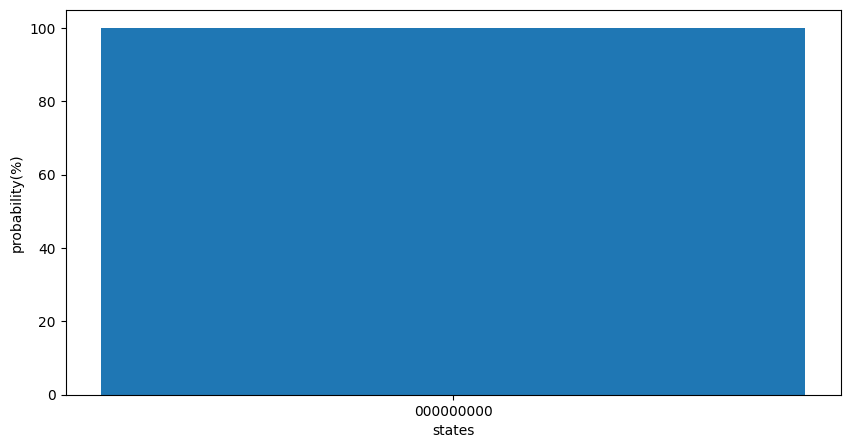

In [237]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

threshold = 0.05  # Only print values whose probability above threshold
indices = np.where(probs > threshold)[0]
z_basis_filtered = [format(i, "b").zfill(num_qubits) for i in indices]
probs_filtered = probs[indices]

plt.figure(figsize=(10, 5))
plt.xlabel("states")
plt.ylabel("probability(%)")
plt.bar(z_basis_filtered, probs_filtered * 100)
plt.show()

In [184]:
print(len(probs))

512


In [ ]:
def add_U_C(circuit: LinearMappedUnboundParametricQuantumCircuit, gamma_idx: int) -> None:
    gamma = circuit.add_parameter(f"gamma_{gamma_idx}")

    N = len(G1.nodes())

    A=1
    B=1
    # ========== Part 1: H_A ==========
    for v in range(N):
        for u in range(N):
            circuit.add_ParametricRZ_gate(qubit_index(u, v, N), {gamma: -2})
        # x_{u1,v} x_{u2,v}
        for u1 in range(N):
            for u2 in range(N):
                add_x_uv_product(obs_dict, u1, v, u2, v, coeff=A, N=N)

    # (2) 每個 u, 令 sum_v x_{u,v} = 1
    for u in range(N):
        add_term(obs_dict, {}, A)
        for v in range(N):
            add_x_uv(obs_dict, u, v, coeff=2.0*A, N=N)
        for v1 in range(N):
            for v2 in range(N):
                add_x_uv_product(obs_dict, u, v1, u, v2, coeff=A, N=N)
    return 